# `GloMarGridding` - Gridded SST with a mask

This notebook demonstrates a simplified approach to infilling a single ensemble from HadSST using a masked `Grid` object using `OrdinaryKriging`. Using a _masked_ grid can improve performance as the kriging weights are not computed for the full grid, only for the unmasked positions.

In [1]:
MONTH, YEAR, MEMBER = 3, 2014, 71

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from glomar_gridding.grid import Grid

# For loading input data
from glomar_gridding.io import load_array

%matplotlib inline

## Define the `Grid`

Initialise a `Grid` using the `from_resolution` constructor method

In [3]:
grid = Grid.from_resolution(
    resolution=5,
    bounds=[(-87.5, 90), (-177.5, 180)],
    coord_names=["latitude", "longitude"],
)
grid.grid

<xarray.DataArray (latitude: 36, longitude: 72)> Size: 21kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(36, 72))
Coordinates:
  * latitude   (latitude) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float64 576B -177.5 -172.5 -167.5 ... 172.5 177.5

## Mask the `Grid`

For the mask we are creating one using ESA CCI SST, we identify positions that are masked within the dataset. We can apply the mask to our `Grid` with the `add_mask` method.

In [4]:
esa_anom = load_array(
    f"./esa_cci_sst_5deg_monthly_1982-2022_{MONTH:02d}.nc", "sst_anomaly"
)

esa_anom = esa_anom.rename({"lat": "latitude", "lon": "longitude"})
mask = np.any(esa_anom.values > 1e5, axis=0)

In [5]:
grid.add_mask(mask)

## Create the distance matrix

The distance matrix accounts for the mask, a distance matrix for the full grid would have size $2592 \times 2592$, whereas in the masked example it is only $1484 \times 1484$. We can compute the distance matrix directly within the `Grid` class with the `distance_matrix` method, which sets the `dist` attribute. It defaults to Haversine distance.

In [6]:
grid.distance_matrix(lat_coord="latitude", lon_coord="longitude")
grid.dist

<xarray.DataArray 'dist' (index_1: 1484, index_2: 1484)> Size: 18MB
array([[    0.        ,   212.70465449,   425.06350855, ...,
        18098.44637053, 18264.58220464, 17622.5039847 ],
       [  212.70465449,     0.        ,   212.70465449, ...,
        17934.02694667, 18098.44637053, 17505.51719321],
       [  425.06350855,   212.70465449,     0.        , ...,
        17771.97921295, 17934.02694667, 17390.88772166],
       ...,
       [18098.44637053, 17934.02694667, 17771.97921295, ...,
            0.        ,   167.136545  ,   792.68998937],
       [18264.58220464, 18098.44637053, 17934.02694667, ...,
          167.136545  ,     0.        ,   897.36684956],
       [17622.5039847 , 17505.51719321, 17390.88772166, ...,
          792.68998937,   897.36684956,     0.        ]],
      shape=(1484, 1484))
Coordinates:
  * index_1      (index_1) int64 12kB 0 1 2 3 4 5 ... 1479 1480 1481 1482 1483
  * index_2      (index_2) int64 12kB 0 1 2 3 4 5 ... 1479 1480 1481 1482 1483
    latitude_1   (index_1) float64 12kB -67.5 -67.5 -67.5 ... 72.5 72.5 77.5
    longitude_1  (index_1) float64 12kB -102.5 -97.5 -92.5 ... 27.5 32.5 7.5
    latitude_2   (index_2) float64 12kB -67.5 -67.5 -67.5 ... 72.5 72.5 77.5
    longitude_2  (index_2) float64 12kB -102.5 -97.5 -92.5 ... 27.5 32.5 7.5

## Covariance

Similarly the covariance matrix accounts for the mask, and can be generated from a variogram using the `covariance_matrix` method. We create it using a variogram. We could alternatively use the `set_covariance` method if we have a pre-computed covariance matrix. This will set the `covariance` attribute and ensure that the mask is applied.

In [7]:
grid.covariance_matrix(
    "matern",
    range=1300,
    psill=1.2,
    nu=1.5,
    nugget=0.0,
    method="sklearn",
)
grid.covariance

<xarray.DataArray 'covariance' (index_1: 1484, index_2: 1484)> Size: 18MB
array([[1.20000000e+00, 1.16001759e+00, 1.06686681e+00, ...,
        1.01570463e-09, 8.21196666e-10, 1.86661819e-09],
       [1.16001759e+00, 1.20000000e+00, 1.16001759e+00, ...,
        1.25343158e-09, 1.01570463e-09, 2.16757190e-09],
       [1.06686681e+00, 1.16001759e+00, 1.20000000e+00, ...,
        1.54199675e-09, 1.25343158e-09, 2.50937848e-09],
       ...,
       [1.01570463e-09, 1.25343158e-09, 1.54199675e-09, ...,
        1.20000000e+00, 1.17431621e+00, 8.58140919e-01],
       [8.21196666e-10, 1.01570463e-09, 1.25343158e-09, ...,
        1.17431621e+00, 1.20000000e+00, 7.97060120e-01],
       [1.86661819e-09, 2.16757190e-09, 2.50937848e-09, ...,
        8.58140919e-01, 7.97060120e-01, 1.20000000e+00]],
      shape=(1484, 1484))
Coordinates:
  * index_1      (index_1) int64 12kB 0 1 2 3 4 5 ... 1479 1480 1481 1482 1483
  * index_2      (index_2) int64 12kB 0 1 2 3 4 5 ... 1479 1480 1481 1482 1483
    latitude_1   (index_1) float64 12kB -67.5 -67.5 -67.5 ... 72.5 72.5 77.5
    longitude_1  (index_1) float64 12kB -102.5 -97.5 -92.5 ... 27.5 32.5 7.5
    latitude_2   (index_2) float64 12kB -67.5 -67.5 -67.5 ... 72.5 72.5 77.5
    longitude_2  (index_2) float64 12kB -102.5 -97.5 -92.5 ... 27.5 32.5 7.5

## Error Covariance

The error covariance is loaded and the mask is applied. Note that this is not added to the `Grid` object. The `prep_covariance` method is used to apply the mask.

In [8]:
error_covariance_path = (
    f"HadCRUT.5.0.2.0.error_covariance.{YEAR}_{MONTH:02d}.nc"
)
uncorrelated_uncertainty_path = (
    f"HadCRUT.5.0.2.0.uncorrelated_{YEAR}_{MONTH:02d}.nc"
)

In [9]:
error_cov = load_array(error_covariance_path, "tas_cov").values[0, ...]
error_cov[error_cov > 1e6] = 0.0
error_cov

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2592, 2592), dtype=float32)

In [10]:
uncorr = load_array(uncorrelated_uncertainty_path, "tas_unc")
uncorr = uncorr.values[:, :].reshape((grid.size,))
uncorr[uncorr > 1e6] = 0.0
uncorr

array([0., 0., 0., ..., 0., 0., 0.], shape=(2592,), dtype=float32)

In [11]:
error_cov += np.diag(np.power(uncorr, 2))
error_cov

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2592, 2592), dtype=float32)

In [12]:
error_cov = grid.prep_covariance(error_cov)

In [13]:
error_cov.shape

(1484, 1484)

In [14]:
error_cov

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.6143992 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.10433086, 0.01901853,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01901853, 0.07595785,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16084467]], shape=(1484, 1484), dtype=float32)

## Observations

The observations are loaded as a `polars.DataFrame`. They are then mapped to the `Grid` using the `map_observations` method which applies the mask and sets the `obs` and `idx` attributes.

In [15]:
obs = pl.from_pandas(
    load_array(
        f"HadSST.4.0.1.0_ensemble_member_{MEMBER}_{YEAR}_{MONTH:02d}.nc", "tos"
    )
    .to_dataframe()
    .reset_index()
)
obs = obs.filter(
    pl.col("time").dt.month().eq(MONTH) & pl.col("time").dt.year().eq(YEAR)
).drop_nulls()
obs = obs.filter(pl.col("tos").lt(1e4))
obs = obs.pipe(
    grid.map_observations, obs_coords=["latitude", "longitude"], obs_col="tos"
)
obs

latitude,longitude,time,tos,grid_latitude,grid_longitude,grid_idx
f64,f64,datetime[ns],f32,f64,f64,u32
-67.5,-97.5,2014-03-16 12:00:00,0.443689,-67.5,-97.5,1
-62.5,-177.5,2014-03-16 12:00:00,0.263557,-62.5,-177.5,4
-62.5,-172.5,2014-03-16 12:00:00,-0.42019,-62.5,-172.5,5
-62.5,-167.5,2014-03-16 12:00:00,-0.923836,-62.5,-167.5,6
-62.5,-157.5,2014-03-16 12:00:00,-0.472038,-62.5,-157.5,8
…,…,…,…,…,…,…
72.5,17.5,2014-03-16 12:00:00,0.923115,72.5,17.5,1479
72.5,22.5,2014-03-16 12:00:00,0.930533,72.5,22.5,1480
72.5,27.5,2014-03-16 12:00:00,1.316632,72.5,27.5,1481


In [16]:
grid.obs

array([ 0.4436895 ,  0.26355723, -0.42019036, ...,  1.3166324 ,
        1.3942208 ,  0.8767654 ], shape=(1238,), dtype=float32)

## Kriging

We can initialise a `Kriging` class within the `Grid` with the `kriging` method. This uses the pre-set `covariance`, `obs`, and `idx` attributes to initialise a `Kriging` class with an optional error covariance.

The `Kriging` class instance is set to the `krige` attribute and can be used in the same way as `Kriging` classes.

In [17]:
grid.kriging("ordinary", error_cov)

In [18]:
grid_idx = obs["grid_idx"].to_numpy()
grid_obs = obs["tos"].to_numpy()

In [19]:
anom_stat = grid.krige.solve()

## Solve the Kriging

We can use the `solve` and other methods of the `Kriging` class in the `krige` attribute.

Finally, we un-mask the outputs of the solution with the `assign_values` method. This maps the masked infilled approximation to the full grid. In this example from 1484 values to 2592 values (with a fill value which defaults to `numpy.nan`.

In [20]:
anom_stat = grid.krige.solve()
uncert_stat = grid.krige.get_uncertainty()

lims_stat = np.max(np.abs(anom_stat))

anom_stat = grid.assign_values(anom_stat)
uncert_stat = grid.assign_values(uncert_stat)

In [21]:
anom_stat

<xarray.DataArray (latitude: 36, longitude: 72)> Size: 21kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(36, 72))
Coordinates:
  * latitude   (latitude) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float64 576B -177.5 -172.5 -167.5 ... 172.5 177.5

In [22]:
lims_stat

np.float64(3.350499911788985)

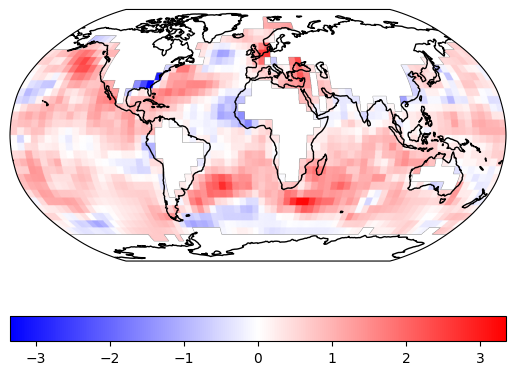

In [23]:
F = plt.Figure()
ax = F.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.coastlines()
m = ax.imshow(
    np.flipud(anom_stat),
    transform=ccrs.PlateCarree(),
    cmap="bwr",
    vmin=-lims_stat,
    vmax=lims_stat,
)
F.colorbar(m, orientation="horizontal")
F